# CA2 Face Recognition                                                                        
# Name：Dong Xinyue ID：E1124282
# Question5: CNN

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image

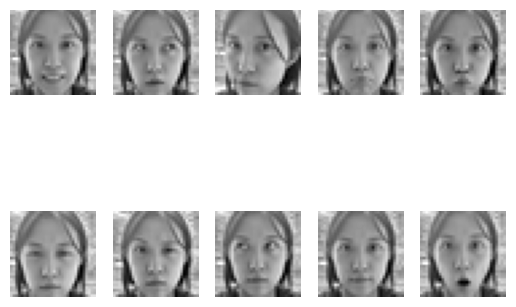

In [2]:
source_dir = os.path.join('PIE', 'my_orgimage')
target_dir = os.path.join('PIE', '69')
if not os.path.exists(target_dir):
    os.mkdir(target_dir)

image_paths = sorted([f for f in os.listdir(source_dir) if f.endswith('.jpg')])
num_rows = 2
num_columns = 5

def process_image(img_path, source_dir, target_dir):
    img = Image.open(os.path.join(source_dir, img_path)).convert('L')
    width, height = img.size
    img = img.crop((width // 8, height // 8, 7 * width // 8, 7 * height // 8)).resize((32, 32), Image.LANCZOS)
    return img

for i, img_path in enumerate(image_paths):
    img = process_image(img_path, source_dir, target_dir)
    plt.subplot(num_rows, num_columns, i % (num_rows * num_columns) + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if not os.path.exists(os.path.join(target_dir, img_path)):
        img.save(os.path.join(target_dir, img_path))
plt.show()

### Whole Dataset

In [3]:
import random
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
random.seed(77)
subjects = [69] + random.sample(range(1, 69), 25)
print('26 subject numbers:', subjects)

n_imgs_subj = [len([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]) for s in subjects]
n_imgs = sum(n_imgs_subj) 
print('number of images per subject: {}'.format(n_imgs_subj))

X = np.empty((n_imgs, 32, 32))
y = np.empty((n_imgs, 1))

for si, s in enumerate(subjects):
    for i, img_path in enumerate([f for f in os.listdir(os.path.join('PIE', str(s))) if f.endswith('.jpg')]):
        img_path = os.path.join('PIE', str(s), str(i+1)+'.jpg')
        X[sum(n_imgs_subj[:si]) + i, :, :] = np.array(Image.open(img_path))
        y[sum(n_imgs_subj[:si]) + i] = s
print('X or dataset shape: {}\ny or label shape: {}'.format(X.shape, y.shape))

# Split the data into CMUPIE and selfie subsets
X_CMUPIE = X[y.flatten() != 69]
y_CMUPIE = y[y != 69]
X_selfies = X[y.flatten() == 69]
y_selfies = y[y == 69]
X_train_CMUPIE, X_test_CMUPIE, y_train_CMUPIE, y_test_CMUPIE = train_test_split(
    X_CMUPIE, y_CMUPIE, test_size=0.3, random_state=77)
X_train_selfies, X_test_selfies, y_train_selfies, y_test_selfies = train_test_split(
    X_selfies, y_selfies, test_size=0.3, random_state=77)
X_train = np.concatenate([X_train_CMUPIE, X_train_selfies], axis=0)
y_train = np.concatenate([y_train_CMUPIE, y_train_selfies], axis=0)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
y_test = np.concatenate([y_test_CMUPIE, y_test_selfies], axis=0)
print('The number of images in train set: {}\nThe number of images in in test set: {}'.format(y_train.shape[0], y_test.shape[0]))

26 subject numbers: [69, 33, 42, 26, 31, 25, 53, 61, 8, 19, 65, 36, 40, 16, 10, 58, 41, 43, 68, 1, 18, 2, 32, 12, 13, 51]
number of images per subject: [10, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170, 170]
X or dataset shape: (4260, 32, 32)
y or label shape: (4260, 1)
The number of images in train set: 2982
The number of images in in test set: 1278


In [5]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchsummary import summary
import time
import copy


random.seed(77)
np.random.seed(77)
rng = random.Random(77)
torch.manual_seed(77)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
class DatasetforCNN(Dataset):
    def __init__(self, X, y, label_dict, transform=None):
        X /= 255.0
        X = X.astype('float32');
        self.X = X.reshape(X.shape[0], 1, 32, 32)
        y = np.array([label_dict[i] for i in y])
        self.y = y.astype(int);
        self.transform = transform
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        sample = {'image': self.X[idx], 'label': np.array([self.y[idx]])}
        if self.transform:
            sample = self.transform(sample)
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}
label_dict = {}
for i, item in enumerate(np.unique(y_train)):
    label_dict[item] = i

Xtrain, Xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.3, random_state=77)
X_test = np.concatenate([X_test_CMUPIE, X_test_selfies], axis=0)
transform = transforms.Compose([ToTensor()])
trainset = DatasetforCNN(Xtrain, ytrain, label_dict, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=0)
valset = DatasetforCNN(Xval, yval, label_dict, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                          shuffle=True, num_workers=0)
testset = DatasetforCNN(X_test, y_test, label_dict, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=0)
dataloaders = {'train': trainloader, 'val': valloader}

class Net(nn.Module):   
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            Conv2d(1, 20, kernel_size=5),
            BatchNorm2d(20),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Conv2d(20, 50, kernel_size=5),
            BatchNorm2d(50),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        self.linear_layers = Sequential( Linear(1250, 26), ReLU(inplace=True))  
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
summary(model, (1, 32, 32)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             520
       BatchNorm2d-2           [-1, 20, 28, 28]              40
              ReLU-3           [-1, 20, 28, 28]               0
         MaxPool2d-4           [-1, 20, 14, 14]               0
            Conv2d-5           [-1, 50, 10, 10]          25,050
       BatchNorm2d-6           [-1, 50, 10, 10]             100
              ReLU-7           [-1, 50, 10, 10]               0
         MaxPool2d-8             [-1, 50, 5, 5]               0
            Linear-9                   [-1, 26]          32,526
             ReLU-10                   [-1, 26]               0
Total params: 58,236
Trainable params: 58,236
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.51
Params size (MB): 0.22
Estimated Tot

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, running_corrects = 0.0, 0
    for item in dataloader:
        inputs = item['image'].to(device)
        labels = item['label'].squeeze(1).to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    return running_loss, running_corrects

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss, running_corrects = 0.0, 0
    with torch.no_grad():
        for item in dataloader:
            inputs = item['image'].to(device)
            labels = item['label'].squeeze(1).to(device).long()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    return running_loss, running_corrects

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, device='cpu'):
    since = time.time()
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        train_loss, train_corrects = train_epoch(model, dataloaders['train'], criterion, optimizer, device)
        train_acc = train_corrects.double() / len(dataloaders['train'].dataset)
        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        val_loss, val_corrects = validate_epoch(model, dataloaders['val'], criterion, device)
        val_acc = val_corrects.double() / len(dataloaders['val'].dataset)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

print("Starting model training and evaluation...")
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)
print("Training and evaluation complete.")
best_val_accuracy = max(hist['val_acc'])
print(f"Best validation accuracy: {best_val_accuracy:.4f}")

Starting model training and evaluation...
Epoch 0/24
----------
Train Loss: 6289.0285 Acc: 0.2108
Val Loss: 2393.0343 Acc: 0.3430
Epoch 1/24
----------
Train Loss: 5097.9298 Acc: 0.4600
Val Loss: 1950.5312 Acc: 0.5419
Epoch 2/24
----------
Train Loss: 4201.9170 Acc: 0.5922
Val Loss: 1551.4372 Acc: 0.6670
Epoch 3/24
----------
Train Loss: 3366.7362 Acc: 0.6938
Val Loss: 1264.9868 Acc: 0.7497
Epoch 4/24
----------
Train Loss: 2729.0757 Acc: 0.7623
Val Loss: 1024.7653 Acc: 0.8078
Epoch 5/24
----------
Train Loss: 2329.0123 Acc: 0.7940
Val Loss: 930.2843 Acc: 0.8123
Epoch 6/24
----------
Train Loss: 2092.2201 Acc: 0.8069
Val Loss: 818.7911 Acc: 0.8313
Epoch 7/24
----------
Train Loss: 1937.0950 Acc: 0.8131
Val Loss: 794.8727 Acc: 0.8302
Epoch 8/24
----------
Train Loss: 1817.6846 Acc: 0.8189
Val Loss: 742.4430 Acc: 0.8335
Epoch 9/24
----------
Train Loss: 1730.1676 Acc: 0.8189
Val Loss: 705.5925 Acc: 0.8380
Epoch 10/24
----------
Train Loss: 1665.6702 Acc: 0.8208
Val Loss: 710.3499 Acc: 0.

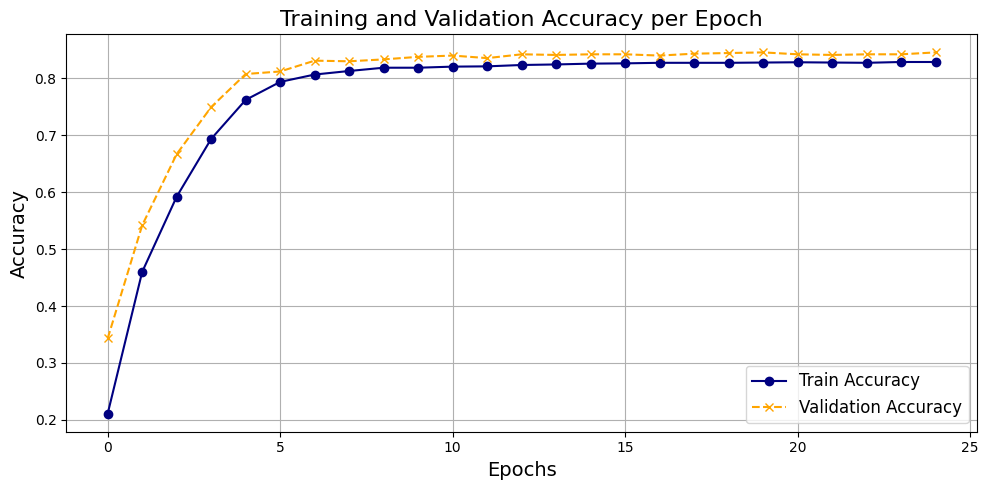

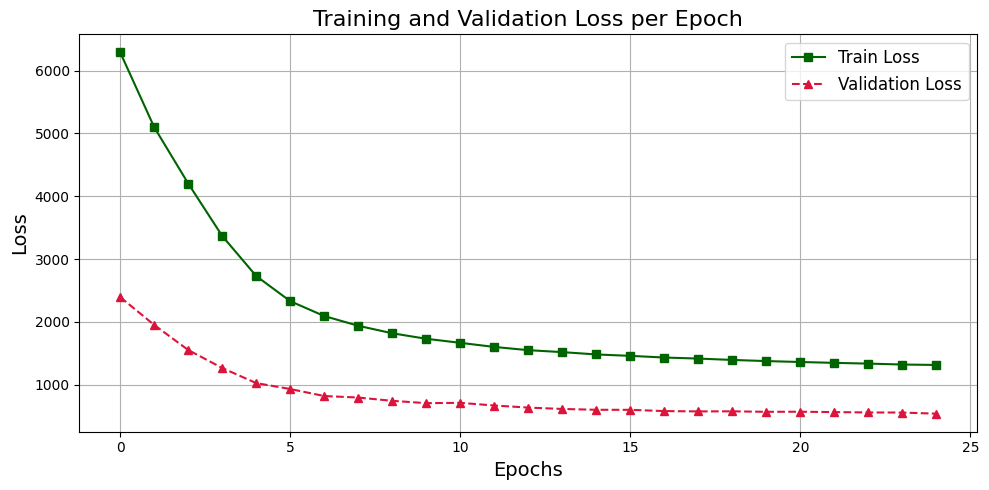

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
hist_df = pd.DataFrame.from_dict(hist)
plt.figure(figsize=(10, 5))
plt.plot(hist_df['train_acc'], label='Train Accuracy', color='navy', linestyle='-', marker='o')
plt.plot(hist_df['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', marker='x') 
plt.title('Training and Validation Accuracy per Epoch', fontsize=16)  
plt.xlabel('Epochs', fontsize=14)  
plt.ylabel('Accuracy', fontsize=14) 
plt.legend(fontsize=12) 
plt.grid(True) 
plt.tight_layout() 
plt.show()  
plt.figure(figsize=(10, 5)) 
plt.plot(hist_df['train_loss'], label='Train Loss', color='darkgreen', linestyle='-', marker='s') 
plt.plot(hist_df['val_loss'], label='Validation Loss', color='crimson', linestyle='--', marker='^')  
plt.title('Training and Validation Loss per Epoch', fontsize=16) 
plt.xlabel('Epochs', fontsize=14)  
plt.ylabel('Loss', fontsize=14)  
plt.legend(fontsize=12) 
plt.grid(True)  
plt.tight_layout()  
plt.show()  

In [11]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data["image"], data["label"].squeeze(1)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

alldataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}

for phase, loader in alldataloaders.items():
    accuracy = calculate_accuracy(loader, model_ft)
    print(f'Accuracy of {phase} images: {accuracy:.2%}')


Accuracy of train images: 82.85%
Accuracy of val images: 84.58%
Accuracy of test images: 83.57%
